# **Trabajo Practico Nº2 - Vision Por Computadora I**

Implementar la función create_gauss_filter(h, w, k_size, sigma) para crear filtros gaussianos para  filtrado espectral. Debe retornar un filtro gaussiano de tamaño HxW en dominio espacial y su transformada de Fourier.

In [224]:
#Si queremos que las imágenes sean mostradas en una ventana emergente quitar el inline
# %matplotlib inline

import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

In [225]:
def gaussian_kernel(size, sigma):
    #Genero los valores de x e y en funcion del size que paso de argumento
    x, y = np.meshgrid(np.arange(size) - size // 2, np.arange(size) - size // 2)

    #Aplico la formula gaussiana para la creacion del kernel del filtro
    kernel = np.exp(-(x**2 + y**2) / (2 * sigma**2))
    kernel = kernel / np.sum(kernel)
    return kernel

def create_gauss_filter(h, w, k_size=5, sigma=5):
    #Creo el kernel con la funcion creada anteriormente
    kernel = gaussian_kernel(k_size, sigma)

    #Compruebo que la altura de la imagen a procesar sea mayor al tamaño del kernel creado
    if h >= kernel.shape[0]:
        x = h - kernel.shape[0]
        padding_x = x//2
        #Verifico que el padding a agregar sea entero, en su defecto le agrego un +1 para compensar que sea impar
        if x % 2 == 0:
            kernel = np.pad(kernel, ((padding_x, padding_x), (0, 0)), 'constant', constant_values=0)
        else:
            kernel = np.pad(kernel, (((padding_x+1), padding_x), (0, 0)), 'constant', constant_values=0) 
    else:
        #Muestro mensaje de error si no cumple la condicion inicial
        print("ERROR el h debe ser mayor o igual al k_size")
        return -1, -1

    #Compruebo que el ancho de la imagen a procesar sea mayor al tamaño del kernel creado
    if w >= kernel.shape[1]:
        y = w - kernel.shape[1]
        padding_y = y//2
        #Verifico que el padding a agregar sea entero, en su defecto le agrego un +1 para compensar que sea impar
        if y % 2 == 0:
            kernel = np.pad(kernel, ((0, 0), (padding_y, padding_y)), 'constant', constant_values=0)
        else:
            kernel = np.pad(kernel, ((0, 0), ((padding_y+1), padding_y)), 'constant', constant_values=0)
    else:
        #Muestro mensaje de error si no cumple la condicion inicial
        print("ERROR el w debe ser mayor o igual al k_size")
        return -1, -1

    #A partir del kernel calculo su fft
    kernel_fft = np.fft.fft2(kernel)
    return kernel, kernel_fft
   
def apply_filter(image, kernel_fft):
    #Obtengo la fft de la imagen
    image_fft = np.fft.fft2(image)

    #Aplico el filtro en el dominio de la frecuencia multiplicando ambas fft
    filtered_image_result = np.fft.ifft2(image_fft * kernel_fft)

    #Me quedo con la parte real del resultado
    filtered_image_real = np.real(filtered_image_result)

    #Convierto a uin8 el resultado final
    filtered_image_real_centrada = np.fft.fftshift(filtered_image_real)
    filtered_image = filtered_image_real_centrada.astype(np.uint8)
    return filtered_image

def plot_filter_and_fft(kernel, kernel_fft, k_size, sigma):
    #Genero la ventana grafica
    plt.figure(figsize=(12,12))

    #Grafico el kernel
    plt.subplot(1,2,1)
    plt.axis('off')
    plt.title(f'Kernel k_size={k_size}, sigma={sigma}')
    plt.imshow(kernel, cmap='jet')

    #Grafico la fft del kernel
    plt.subplot(1,2,2)
    plt.axis('off')
    plt.title(f'Kernel FFT k_size={k_size}, sigma={sigma}')
    plt.imshow(np.abs(np.fft.fftshift(kernel_fft)), cmap='jet')

def plot_image(image, img_gauss, k_size, sigma):
    #Genero la ventana grafica
    plt.figure(figsize=(12,12))

    #Grafico la imagen
    plt.subplot(1,2,1)
    plt.axis('off')
    plt.imshow(image, cmap='gray')
    plt.title('Imagen en escala de grises')
    
    #Grafico la imagen filtrada por el kernel
    plt.subplot(1,2,2)
    plt.axis('off')
    plt.imshow(img_gauss, cmap='gray')
    plt.title(f'Desenfoque gausiano con k_size={k_size}, sigma={sigma}')

1. Graficar ambas representaciones para diferentes tamaños de kernel y sigma. Aplicar el filtro una imagen para validar el funcionamiento en el dominio espectral.

In [226]:
#Cargo la imagen en escala de grises
img = cv.imread('Perritos.jpg', cv.IMREAD_GRAYSCALE)
#Obtengo el alto y ancho de la misma
h, w= img.shape
#Muestro los valores
print(f'La imagen tiene una altura de {h} y un ancho de {w}')

La imagen tiene una altura de 720 y un ancho de 1280


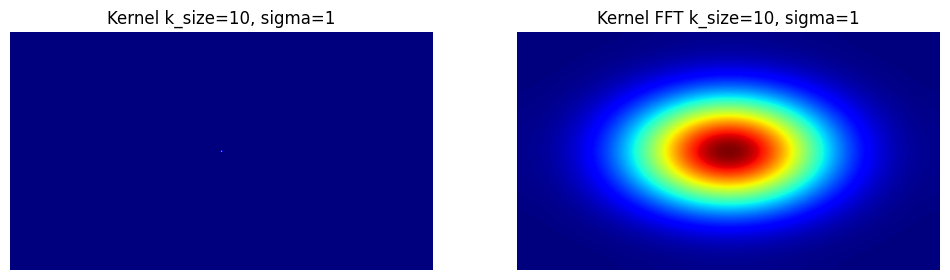

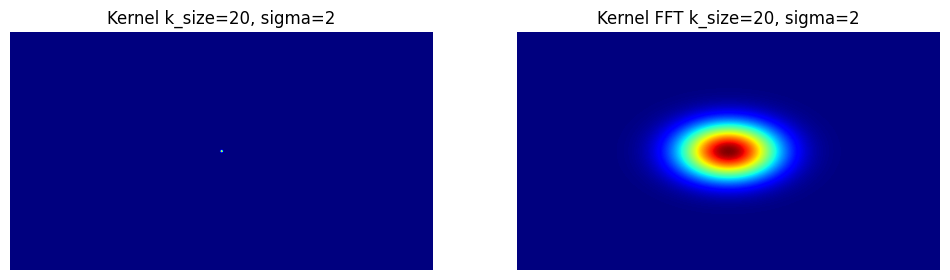

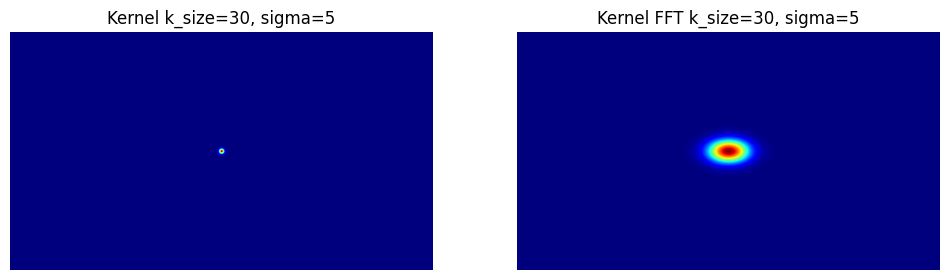

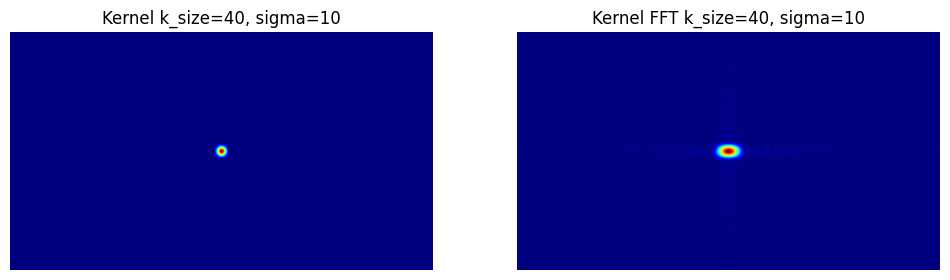

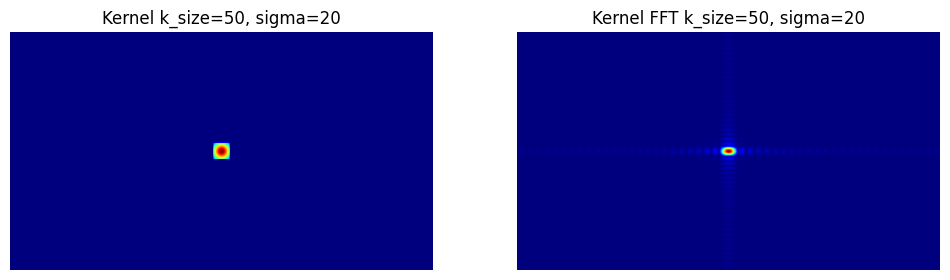

In [227]:
#Arreglos para diferente valores de k_sizes y sigmas
k_sizes = [10, 20, 30, 40, 50]
sigmas = [1, 2, 5, 10, 20]

#Calculo el kernel para cada valor de k_sizes y sigmas y luego muestro el resultado del filtro obtenido con su fft
for i in range(len(k_sizes)):
    kernel, kernel_tf = create_gauss_filter(h, w, k_sizes[i], sigmas[i])
    plot_filter_and_fft(kernel, kernel_tf, k_sizes[i], sigmas[i])

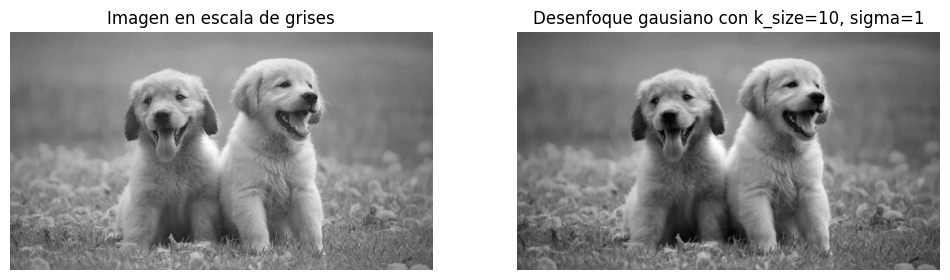

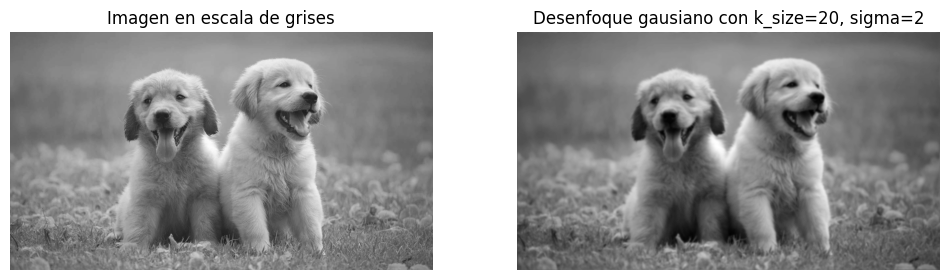

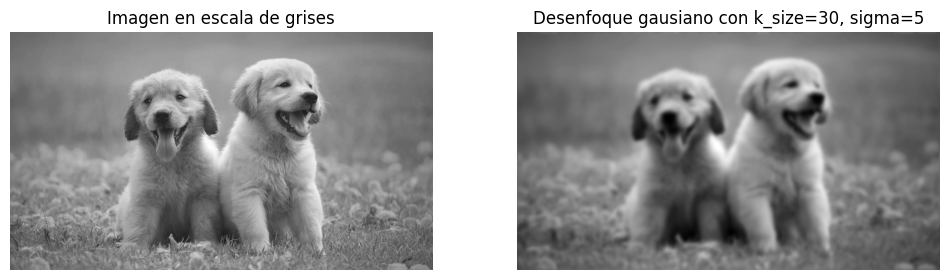

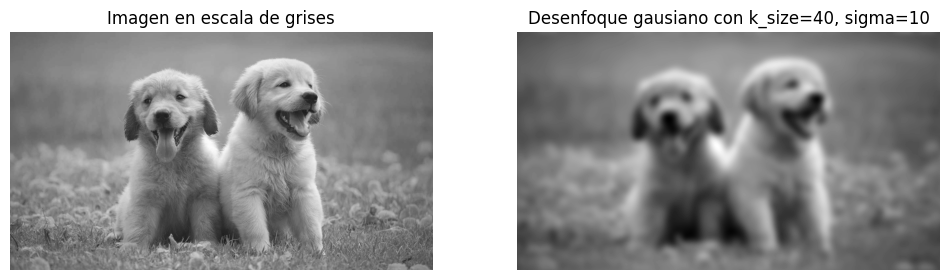

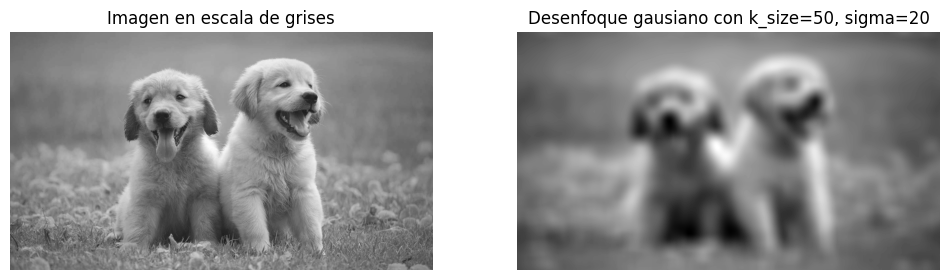

In [228]:
#Arreglos para diferente valores de k_sizes y sigmas
k_sizes = [10, 20, 30, 40, 50]
sigmas = [1, 2, 5, 10, 20]

#Calculo el kernel para cada valor de k_sizes y sigmas y luego le aplico el filtro generado a la imagen y muestro el resultado
for i in range(len(k_sizes)):
    kernel, kernel_tf = create_gauss_filter(h, w, k_sizes[i], sigmas[i])
    img_gauss = apply_filter(img, kernel_tf) 
    plot_image(img, img_gauss, k_sizes[i], sigmas[i])

## Conclusiones

### Se observa que al incrementar el valor del parametro sigma aparecen más componentes de alta frecuencia en la transformada de fourier del kernel. Esto genera un desenfoque mayor en la imagen filtrada.

2. Usando el método descripto en el paper “Image Sharpness Measure for Blurred Images in Frequency Domain” comparar el resultado de un filtrado por convolución con el filtrado espectral.

In [230]:
#Algorithm for image quality measure
def calc_FM(img):
    #Calculo F, que es la transformada de Fourier de la imagen
    F = np.fft.fft2(img)

    #Encuentro Fc que se obtiene desplazando el origen de F al centro.
    FC = np.fft.fftshift(F)

    #Calculo AF ques es el valor absoluto de la transformada de Fourier centrada de la imagen
    AF = np.abs(FC)

    #Calculo M ) que es el valor máximo del componente de frecuencia en F
    M = np.max(AF)

    #Calculo TH que es el número total de píxeles en F cuyo valor de píxel > thres, donde thres = M/1000
    T_H = np.count_nonzero(F > (M/1000))

    #Calculo la medida de calidad de imagen
    FM = T_H/(img.shape[0]*img.shape[1])
    
    return FM

In [231]:
# Genero el filtro gaussiano
kernel, kernel_tf = create_gauss_filter(h, w, k_size=50, sigma=20)
# Filtro en el espectro 
img_a = apply_filter(img, kernel_tf) 

# Filtro en el espacio por convolucion
img_b = cv.filter2D(img, -1, kernel)

# Comparacion de los resultados
print(calc_FM(img_a), calc_FM(img_b))

0.0002224392361111111 0.0002224392361111111


3. Repetir la comparación usando uno de los métodos descriptos en el apéndice del paper “Analysis of focus measure operators in shape-from-focus”.

In [232]:
#Absolute central moment
def calc_ACM(image):
    #Inicio la variable de salida en cero
    ACM = 0

    #Genero el histograma de la imagen
    histogram = cv.calcHist([image], [0], None, [256], [0, 256])

    #Claculo el valor medio
    mean = np.mean(image)

    #Realizo la sumatoria
    for i in range(len(histogram)):
        ACM += histogram[i] * np.abs(i - mean)
    
    #Muestro el resultado escalandolo
    return ACM/(img.shape[0]*img.shape[1])

In [233]:
# Genero el filtro gaussiano
kernel, kernel_tf = create_gauss_filter(h, w, k_size=50, sigma=20)
# Filtro en el espectro 
img_a = apply_filter(img, kernel_tf) 

# Filtro en el espacio por convolucion
img_b = cv.filter2D(img, -1, kernel)

# Comparacion de los resultados
print(calc_ACM(img_a), calc_ACM(img_b))

[17.57540256] [17.58879666]


## Conclusiones

### Se puede apreciar que los resultados logrados en cada caso son los esperados ya que dan valores similares al aplicarse las funciones utilizadas para la comparación. La unica diferencia se halla en que en un caso se realiza el filtrado en el dominio espectral (apply_filter) y en el otro en el dominio espacial (filter2D). Lo que muestra es que ambos procesos son iguales ya que la operacion solo es realizada en otro dominio para simplicar su resolucion matematica.